In [1]:
import os
import torch
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torchvision
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms 
from torchvision import models as m
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
import datetime
import gc  #garbage collector
from torchinfo import summary
from timm.models.vision_transformer import VisionTransformer
import json

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [4]:
dir(m)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights',
 'RegNet_X_1_6GF_Weights',
 'R

In [4]:
torch.cuda.manual_seed(1412)
torch.cuda.manual_seed_all(1412)

In [4]:
#执行此代码时注意关闭VPN
IncV3 = m.inception_v3(pretrained=True) #resnet18_pretrained
#将导入的预训练模型中所有的参数锁住
for param in IncV3.parameters():
    param.requires_grad = False

In [5]:
num_ftrs = IncV3.fc.in_features  # 获取低级特征维度
IncV3.fc = nn.Linear(num_ftrs, 4)

In [6]:
net1 = IncV3

In [9]:
summary(net1,input_size=(10,3,224,224),depth=3,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [10, 4]                   3,326,696
├─BasicConv2d: 1-1                       [10, 32, 111, 111]        --
│    └─Conv2d: 2-1                       [10, 32, 111, 111]        (864)
│    └─BatchNorm2d: 2-2                  [10, 32, 111, 111]        (64)
├─BasicConv2d: 1-2                       [10, 32, 109, 109]        --
│    └─Conv2d: 2-3                       [10, 32, 109, 109]        (9,216)
│    └─BatchNorm2d: 2-4                  [10, 32, 109, 109]        (64)
├─BasicConv2d: 1-3                       [10, 64, 109, 109]        --
│    └─Conv2d: 2-5                       [10, 64, 109, 109]        (18,432)
│    └─BatchNorm2d: 2-6                  [10, 64, 109, 109]        (128)
├─MaxPool2d: 1-4                         [10, 64, 54, 54]          --
├─BasicConv2d: 1-5                       [10, 80, 54, 54]          --
│    └─Conv2d: 2-7                       [10, 80, 54, 54]

In [7]:
model =IncV3.to(device)
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root)

    # 遍历文件夹，一个文件夹对应一个类别
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    # 排序，保证各平台顺序一致
    flower_class.sort()
    # 生成类别名称以及对应的数字索引
    class_indices = dict((k, v) for v, k in enumerate(flower_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 排序，保证各平台顺序一致
        images.sort()
        # 获取该类别对应的索引
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num)))
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))
    assert len(train_images_path) > 0, "number of training images must greater than 0."
    assert len(val_images_path) > 0, "number of validation images must greater than 0."
    
    plot_image = False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(flower_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(flower_class)), flower_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label

In [16]:
class MyDataSet():
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        # RGB为彩色图片，L为灰度图片
        if img.mode != 'RGB':
            raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [19]:
data_path = "/home/ubuntu/fy/diabetic retinopathy/feature selection/data/seg_VB_512tofeature"

In [20]:
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(data_path)

1200 images were found in the dataset.
961 images for training.
239 images for validation.


In [21]:
img_size = 224
data_transform = {
        "train": transforms.Compose([
#                                      transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([
#                                  transforms.Resize(int(img_size * 1.143)),
#                                    transforms.CenterCrop(img_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

# 实例化训练数据集
train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                               transform=data_transform["train"]
                         )

# 实例化验证数据集
val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                           transform=data_transform["val"]
                       )



In [22]:
batch_size=32
batchdata = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               drop_last=True,
                                               collate_fn=train_dataset.collate_fn)


testdata = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                            drop_last=True,
                                             collate_fn=val_dataset.collate_fn)


dataloaders = {'train': batchdata , 'val': testdata }
dataset_sizes = {'train': len( batchdata), 'val': len(testdata)}

In [23]:
from torch.optim import lr_scheduler

import copy

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.Adam(model.parameters())

# 定义学习率调度器
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 开始训练模型
num_epochs = 100
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# 初始化记录器
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # 每个epoch都有一个训练和验证阶段
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # 遍历数据
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 零参数梯度
            optimizer.zero_grad()

            # 前向
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 只在训练模式下进行反向和优化
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # 统计
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

        # 记录每个epoch的loss和accuracy
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # 深拷贝模型
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

print('Best val Acc: {:4f}'.format(best_acc))

# 加载最佳模型权重
#model.load_state_dict(best_model_wts)
#torch.save(model, 'shufflenet_best_model.pth')
#print("The trained model has been saved.")

Epoch 0/99
----------


TypeError: max() received an invalid combination of arguments - got (InceptionOutputs, int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [ ]:

epoch = range(1, len(train_loss_history)+1)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(epoch, train_loss_history, label='Train loss')
ax[0].plot(epoch, val_loss_history, label='Validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epoch, train_acc_history, label='Train acc')
ax[1].plot(epoch, val_acc_history, label='Validation acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

#plt.savefig("loss-acc.pdf", dpi=300,format="pdf")

C:\Users\22394\AppData\Local\Temp\ipykernel_25352\4196878188.py:58: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_val = d_val/(b_val+d_val)  # 精确度
C:\Users\22394\AppData\Local\Temp\ipykernel_25352\4196878188.py:60: RuntimeWarning: invalid value encountered in true_divide
  MCC_val = (d_val*a_val-b_val*c_val) / (np.sqrt((d_val+b_val)*(d_val+c_val)*(a_val+b_val)*(a_val+c_val)))  # 马修斯相关系数


验证集的灵敏度为： 0.0 验证集的特异度为： 1.0 验证集的准确率为： 0.25 验证集的错误率为： 0.75 验证集的精确度为： nan 验证集的F1为： nan 验证集的MCC为： nan


C:\Users\22394\AppData\Local\Temp\ipykernel_25352\4196878188.py:87: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_train = d_train/(b_train+d_train)
C:\Users\22394\AppData\Local\Temp\ipykernel_25352\4196878188.py:89: RuntimeWarning: invalid value encountered in true_divide
  MCC_train = (d_train*a_train-b_train*c_train) / (math.sqrt((d_train+b_train)*(d_train+c_train)*(a_train+b_train)*(a_train+c_train)))


训练集的灵敏度为： 0.0 训练集的特异度为： 1.0 训练集的准确率为： 0.8095238095238095 训练集的错误率为： 0.19047619047619047 训练集的精确度为： nan 训练集的F1为： nan 训练集的MCC为： nan


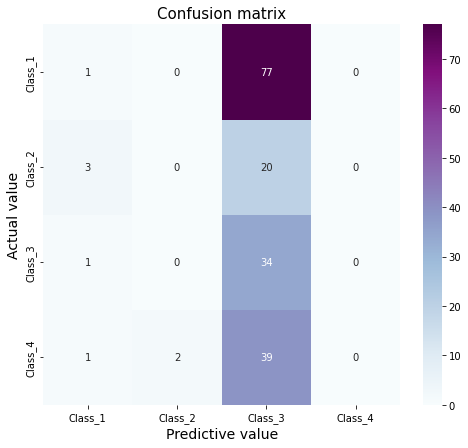

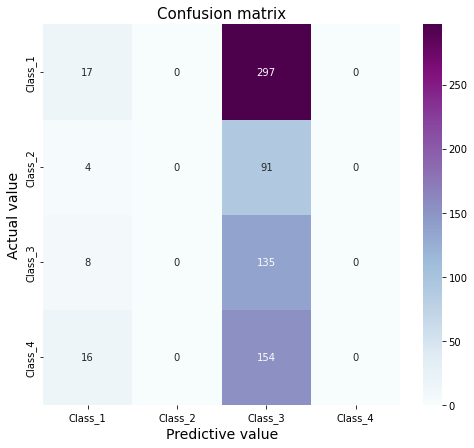

In [18]:

from sklearn.metrics import classification_report, confusion_matrix
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import imshow

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('Confusion matrix',fontsize=15)
    plt.ylabel('Actual value',fontsize=14)
    plt.xlabel('Predictive value',fontsize=14)
    
def evaluate_model(model, dataloader, device):
    model.eval()   # 设置模型为评估模式
    true_labels = []
    pred_labels = []
    # 遍历数据
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        
    return true_labels, pred_labels

# 获取预测和真实标签
true_labels, pred_labels = evaluate_model(model, dataloaders['val'], device)

# 计算混淆矩阵
cm_val = confusion_matrix(true_labels, pred_labels)
a_val = cm_val[0,0]
b_val = cm_val[0,1]
c_val = cm_val[1,0]
d_val = cm_val[1,1]

# 计算各种性能指标
acc_val = (a_val+d_val)/(a_val+b_val+c_val+d_val)  # 准确率
error_rate_val = 1 - acc_val  # 错误率
sen_val = d_val/(d_val+c_val)  # 灵敏度
sep_val = a_val/(a_val+b_val)  # 特异度
precision_val = d_val/(b_val+d_val)  # 精确度
F1_val = (2*precision_val*sen_val)/(precision_val+sen_val)  # F1值
MCC_val = (d_val*a_val-b_val*c_val) / (np.sqrt((d_val+b_val)*(d_val+c_val)*(a_val+b_val)*(a_val+c_val)))  # 马修斯相关系数

# 打印出性能指标
print("验证集的灵敏度为：", sen_val, 
      "验证集的特异度为：", sep_val,
      "验证集的准确率为：", acc_val, 
      "验证集的错误率为：", error_rate_val,
      "验证集的精确度为：", precision_val, 
      "验证集的F1为：", F1_val,
      "验证集的MCC为：", MCC_val)

# 绘制混淆矩阵
plot_cm(true_labels, pred_labels)

    
# 获取预测和真实标签
train_true_labels, train_pred_labels = evaluate_model(model, dataloaders['train'], device)
# 计算混淆矩阵
cm_train = confusion_matrix(train_true_labels, train_pred_labels)  
a_train = cm_train[0,0]
b_train = cm_train[0,1]
c_train = cm_train[1,0]
d_train = cm_train[1,1]
acc_train = (a_train+d_train)/(a_train+b_train+c_train+d_train)
error_rate_train = 1 - acc_train
sen_train = d_train/(d_train+c_train)
sep_train = a_train/(a_train+b_train)
precision_train = d_train/(b_train+d_train)
F1_train = (2*precision_train*sen_train)/(precision_train+sen_train)
MCC_train = (d_train*a_train-b_train*c_train) / (math.sqrt((d_train+b_train)*(d_train+c_train)*(a_train+b_train)*(a_train+c_train))) 
print("训练集的灵敏度为：",sen_train, 
      "训练集的特异度为：",sep_train,
      "训练集的准确率为：",acc_train, 
      "训练集的错误率为：",error_rate_train,
      "训练集的精确度为：",precision_train, 
      "训练集的F1为：",F1_train,
      "训练集的MCC为：",MCC_train)

# 绘制混淆矩阵
plot_cm(train_true_labels, train_pred_labels)

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import pandas as pd
import math

def plot_roc_micro(name, labels, predictions, class_names, **kwargs):
    # Compute micro-average ROC curve and ROC AUC score
    fpr, tpr, _ = metrics.roc_curve(pd.get_dummies(labels).values.ravel(), predictions.ravel())
    roc_auc = metrics.auc(fpr, tpr)
    
    # Plot the micro-average ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=name+' (micro-average AUC = {0:.2f})'.format(roc_auc), linewidth=2, **kwargs)
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    plt.legend(loc='lower right')
    ax = plt.gca()
    ax.set_aspect('equal')

# Assuming you have defined `class_names` as a list of four class names
class_names = ['Class_1', 'Class_2', 'Class_3', 'Class_4']

val_pre_auc = []
val_label_auc = []

train_ds = dataloaders['train']
val_ds = dataloaders['val']

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_ds:
        images = images.to(device)
        labels = labels.to(device)
        predictions_auc = model(images)
        val_pre_auc.append(predictions_auc.cpu().numpy())  # Output probabilities for all classes
        val_label_auc.append(labels.cpu().numpy())

val_pre_auc = np.vstack(val_pre_auc)
val_label_auc = np.hstack(val_label_auc)

plot_roc_micro('validation AUC', val_label_auc, val_pre_auc, class_names, color="red", linestyle='--')

# Compute the ROC AUC score for the validation set
auc_score_val = metrics.roc_auc_score(pd.get_dummies(val_label_auc), val_pre_auc, multi_class='ovr')

train_pre_auc = []
train_label_auc = []

model.train()  # Set the model back to training mode
with torch.no_grad():
    for images, labels in train_ds:
        images = images.to(device)
        labels = labels.to(device)
        predictions_auc = model(images)
        train_pre_auc.append(predictions_auc.cpu().numpy())
        train_label_auc.append(labels.cpu().numpy())

train_pre_auc = np.vstack(train_pre_auc)
train_label_auc = np.hstack(train_label_auc)

plot_roc_micro('training AUC', train_label_auc, train_pre_auc, class_names, color="blue", linestyle='--')

# Compute the ROC AUC score for the training set
auc_score_train = metrics.roc_auc_score(pd.get_dummies(train_label_auc), train_pre_auc, multi_class='ovr')

plt.legend(loc='lower right')
plt.show()

print("训练集的AUC值为：", auc_score_train, "验证集的AUC值为：", auc_score_val)


NameError: name 'val_ds' is not defined